In [7]:
import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings

%load_ext watermark
%matplotlib inline


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [8]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "05c_dl-baseline-keras" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [9]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [10]:
#train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
#test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')

train_df = pd.read_pickle(PATH_DATA_INT+'train-opt-fe.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt-fe.pkl')

sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [11]:
features_num = train_df.drop(['target'], axis=1).columns
X = train_df.drop(['target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.copy()


# Scaling

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### standardize data
scaler = StandardScaler()
# scaler = MinMaxScaler()
#scaler = RobustScaler()

X = pd.DataFrame(columns=X.columns, data=scaler.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

# Modeling

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import datatable as dt
import tensorflow as tf
from tensorflow import keras

In [14]:
### check gpu before training
print("Tensorflow Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Number of GPUs Available:  1


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=20, 
    verbose=0,
    mode='min', 
    baseline=None, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # TODO: test val_auc as monitor
    factor=0.2,
    patience=5,
    mode='min' # TODO: set to max when val_auc
)

In [16]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization

### create baseline-model
# TODO: Re-write model in Sequential-style

def get_model():
    inp = Input(shape=X.shape[1], name="input")
    #h = BatchNormalization()(inp)
    #h = Dense(128, activation="swish")(h)
    h = Dense(128, activation="swish")(inp)
    h = Dropout(0.25)(h)
    h = Dense(64, activation="swish")(h)
    h = Dropout(0.25)(h)
    h = Dense(32, activation="swish")(h)
    h = Dropout(0.25)(h)
    h = Dense(1, activation="sigmoid")(h)

    model = Model(inputs=inp, outputs=h)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-3),
        metrics=["AUC"],
    )
    
    return model


In [17]:
import gc
from sklearn.model_selection import StratifiedKFold
from keras.backend import clear_session

EPOCHS = 100
BATCH_SIZE = 1024
VERBOSE = 0
N_SPLITS = 10

# Cross-validation 
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=rnd_state)

scores = {fold:None for fold in range(cv.n_splits)}
print(scores)
predictions = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):

    clear_session()
    gc.collect()

    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    #X_train = pd.DataFrame(columns=X.columns, data=scaler.fit_transform(X_train))
    #X_valid = pd.DataFrame(columns=X.columns, data=scaler.transform(X_valid))
    #X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))
    
    model = get_model()

    print('**'*20)
    print(f"Fold {fold+1} || Training")
    print('**'*20)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=[
            early_stopping,
            reduce_lr
        ]
    )
    
    scores[fold] = (history.history)
    
    print(f"Fold {fold+1} || Max Validation AUC: {np.max(scores[fold]['val_auc'])}")
    
    prediction = model.predict(X_test, batch_size=BATCH_SIZE).reshape(1,-1)[0]
    predictions.append(prediction)

print('**'*20)
print('Finished Training')
print('**'*20)

overall_auc = [np.max(scores[fold]['val_auc']) for fold in range(cv.n_splits)]
print('Overall Mean AUC: ', np.mean(overall_auc))

{0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None}
****************************************
Fold 1 || Training
****************************************
Fold 1 || Max Validation AUC: 0.7549660801887512
****************************************
Fold 2 || Training
****************************************
Fold 2 || Max Validation AUC: 0.7579164505004883
****************************************
Fold 3 || Training
****************************************
Fold 3 || Max Validation AUC: 0.7544540166854858
****************************************
Fold 4 || Training
****************************************
Fold 4 || Max Validation AUC: 0.7553406357765198
****************************************
Fold 5 || Training
****************************************
Fold 5 || Max Validation AUC: 0.7568165063858032
****************************************
Fold 6 || Training
****************************************
Fold 6 || Max Validation AUC: 0.7587049603462219
*********

## Results

**train-opt**:
- StandardScaler: 0.7599881112575531 | Kaggle: 0.74748
- RobustScaler: 0.758339524269104
- Scaling after split: 0.7598047852516174
- Keras BatchNormalization Input: 0.7596516966819763 | Kaggle: 0.74684


**train-opt-fe**:
- StandardScaler: 0.7571900427341461 | Kaggle: 0.74840


## Plotting metrics recorded during training


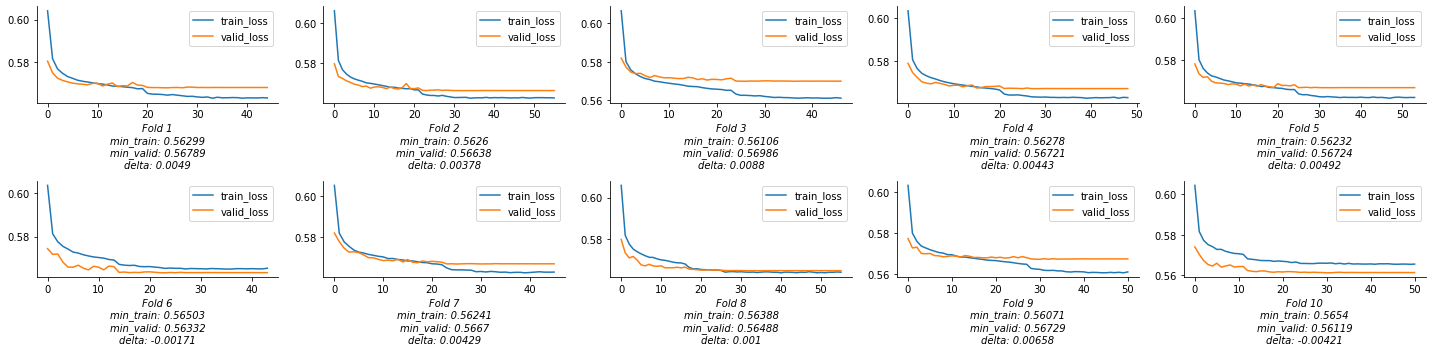

In [22]:
### plot train and valid loss over number of epochs
fig, ax = plt.subplots(2, 5, tight_layout=True, figsize=(20,5))
ax = ax.flatten()

for fold in range(cv.n_splits):
    df_eval = pd.DataFrame({'train_loss': scores[fold]['loss'], 'valid_loss': scores[fold]['val_loss']})

    min_train = np.round(np.min(df_eval['train_loss']),5)
    min_valid = np.round(np.min(df_eval['valid_loss']),5)
    delta = np.round(min_valid - min_train,5)
    
    sns.lineplot(
        x=df_eval.index,
        y=df_eval['train_loss'],
        label='train_loss',
        ax = ax[fold]
    )

    sns.lineplot(
        x=df_eval.index,
        y=df_eval['valid_loss'],
        label='valid_loss',
        ax = ax[fold]
    )
    
    ax[fold].set_ylabel('')
    ax[fold].set_xlabel(f"Fold {fold+1}\nmin_train: {min_train}\nmin_valid: {min_valid}\ndelta: {delta}", fontstyle='italic')

sns.despine()

In [23]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

# mlflow_run_id = str(run.info.run_id)
objective = "dl_keras-baseline-StandardScaler-train-opt-fe"

curr_submission_fn = f"{now}_submission_{objective}.csv"

# sample_df['target'] = preds_test
sample_df["target"] = np.mean(np.column_stack(predictions), axis=1)
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)


2021-11-17_submission_dl_keras-baseline-StandardScaler-train-opt-fe.csv


In [24]:
sample_df.head()

,id,target
0,600000,0.720723
1,600001,0.697921
2,600002,0.754763
3,600003,0.225638
4,600004,0.707509


In [26]:
!kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}

Successfully submitted to Tabular Playground Series - Nov 2021



  0%|          | 0.00/9.68M [00:00<?, ?B/s]
  0%|          | 8.00k/9.68M [00:00<02:09, 78.2kB/s]
  1%|          | 112k/9.68M [00:00<00:16, 619kB/s]  
  2%|▏         | 208k/9.68M [00:00<00:13, 750kB/s]
  3%|▎         | 288k/9.68M [00:00<00:18, 525kB/s]
  4%|▎         | 352k/9.68M [00:00<00:21, 458kB/s]
  4%|▍         | 408k/9.68M [00:00<00:22, 425kB/s]
  5%|▍         | 456k/9.68M [00:01<00:23, 417kB/s]
  5%|▌         | 504k/9.68M [00:01<00:24, 397kB/s]
  6%|▌         | 552k/9.68M [00:01<00:26, 369kB/s]
  6%|▌         | 592k/9.68M [00:01<00:25, 370kB/s]
  6%|▋         | 640k/9.68M [00:01<00:25, 375kB/s]
  7%|▋         | 680k/9.68M [00:01<00:25, 376kB/s]
  7%|▋         | 720k/9.68M [00:01<00:25, 373kB/s]
  8%|▊         | 760k/9.68M [00:01<00:25, 375kB/s]
  8%|▊         | 800k/9.68M [00:01<00:25, 367kB/s]
  8%|▊         | 840k/9.68M [00:02<00:25, 363kB/s]
 10%|█         | 0.98M/9.68M [00:02<00:12, 726kB/s]
 11%|█         | 1.06M/9.68M [00:02<00:16, 559kB/s]
 12%|█▏        | 1.12M/9.68M [0